In [1]:
import ee
import geemap

In [2]:
Map = geemap.Map()

In [3]:
ee.Initialize()

In [4]:
from utils.utils import correct_image_shape, milsec2date, read_csv
from utils.ee_utils import get_cloud_mask, get_square_roi, get_mask_ones_ratio

In [5]:
roi = get_square_roi(52.37962731,7.164954376, roi_size=1920, return_gee_object=True)
Map = geemap.Map(zoom=12)
Map.addLayer(roi)
Map.centerObject(roi)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [6]:
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate('2015-01-01', '2015-12-31') \
                .filter(ee.Filter.lt('CLOUD_COVER',10)) \
                .filterBounds(roi) \
                #.filter(ee.Filter.contains('.geo', roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene
print(l8.size().getInfo())
print('Date:',milsec2date(l8.aggregate_array('system:time_start').getInfo()))

6
Date: ['2015-04-15', '2015-07-04', '2015-08-05', '2015-08-21', '2015-09-29', '2015-09-29']


In [7]:
l8_img = l8.median().clip(roi).multiply(2.75e-05).add(-0.2)
bands = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
l8_img = l8_img.select(bands)

In [8]:
geemap.download_ee_image(l8_img, "l8.tif",crs='EPSG:3857', scale=30,region = roi)

l8.tif: |          | 0.00/623k (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


In [9]:
from skimage import io
import numpy as np
l8_np = io.imread('l8.tif')
print(l8_np.shape)
l8_np = correct_image_shape(l8_np)
print(l8_np.shape)
print(np.min(l8_np),np.max(l8_np))

(7, 106, 105)
(106, 105, 7)
0.007336249999999989 0.5202662499999999


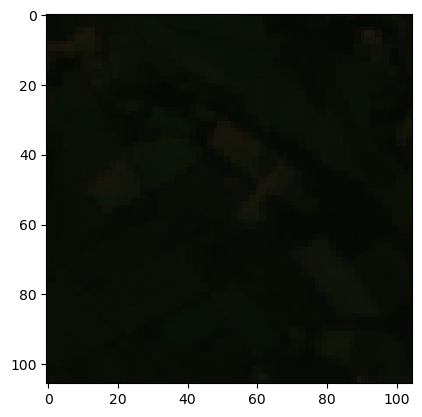

In [10]:
import matplotlib.pyplot as plt
plt.imshow(l8_np[:,:,[3,2,1]])

In [11]:
df = read_csv("LUCAS_2015_Germany.csv")
df

,Piont_id,long,lat
0,40463116,6.072879,51.088722
1,40463188,6.016994,51.734784
2,40523090,6.177697,50.858239
3,40523108,6.164374,51.019789
4,40543118,6.185448,51.110477
...,...,...,...
1681,46543152,14.786924,51.380586
1682,46563124,14.789346,51.128352
1683,46603108,14.831361,50.982524
1684,46623118,14.869216,51.070995


In [12]:
for index, row in df.iterrows():
    print(f'Point {index}' , end=" -> ")
    roi = get_square_roi(row['lat'],row['long'], roi_size=1920, return_gee_object=True)
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate('2015-01-01', '2015-12-31') \
                .filter(ee.Filter.lt('CLOUD_COVER',10)) \
                .filterBounds(roi).sort('system:time_start')
                #.filter(ee.Filter.contains('.geo', roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene
    #print(l8.size().getInfo())
    print('Date:',milsec2date(l8.aggregate_array('system:time_start').getInfo()))
    
    if index == 5:
        break

Point 0 -> Date: ['2015-01-07', '2015-03-12', '2015-07-11', '2015-08-03', '2015-09-29', '2015-09-29', '2015-12-09']
Point 1 -> Date: ['2015-01-07', '2015-03-12', '2015-08-03', '2015-09-29', '2015-12-09']
Point 2 -> Date: ['2015-07-11', '2015-09-29', '2015-09-29']
Point 3 -> Date: ['2015-01-07', '2015-03-12', '2015-07-11', '2015-08-03', '2015-09-29', '2015-09-29', '2015-12-09']
Point 4 -> Date: ['2015-01-07', '2015-03-12', '2015-07-11', '2015-08-03', '2015-09-29', '2015-09-29', '2015-12-09']
Point 5 -> Date: ['2015-04-15', '2015-07-04', '2015-07-11', '2015-08-05', '2015-08-21', '2015-09-29']


In [14]:
l8_c = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate('2015-01-01', '2015-12-31') \
                .filter(ee.Filter.gt('CLOUD_COVER',20)) \
                .filter(ee.Filter.lt('CLOUD_COVER',60)) \
                .filterBounds(roi).sort('CLOUD_COVER', True)
                #.filter(ee.Filter.contains('.geo', roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene
print(l8_c.size().getInfo())
print('Date:',milsec2date(l8_c.aggregate_array('system:time_start').getInfo()))

6
Date: ['2015-06-25', '2015-04-22', '2015-05-08', '2015-10-31', '2015-08-12', '2015-06-09']


In [18]:
Map = geemap.Map()

l8_c_img = l8_c.first()
qa = l8_c_img.select('QA_PIXEL')
rgb = l8_c_img.select('SR_B4','SR_B3','SR_B2').multiply(2.75e-05).add(-0.2)
#cloud = qa.bitwiseAnd(1<<2).And(qa.bitwiseAnd(1<<6)).Or(qa.bitwiseAnd(1<<7))

# Define the cloud, cloud shadow, and snow/ice bits.
cloud = get_cloud_mask(l8_c_img)[0]
print(cloud.bandNames().getInfo())
cloudShadow = get_cloud_mask(l8_c_img)[1]

mask = cloud.where(cloud, 1)
mask = mask.where(cloudShadow, 2)

#Display the cloud mask on the map
Map.addLayer(mask, {'min': 0, 'max': 1, 'palette': ['000000', 'red', 'blue']}, 'Mask')

visualization = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.3,
}

maskedImage = rgb.updateMask(cloud.Not())
Map.addLayer(maskedImage.clip(roi), visualization, 'masked')
Map.centerObject(roi)
Map

['QA_PIXEL']


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [16]:
masked_cliped = cloud.clip(roi)

# Compute the number of ones and total number of pixels in the mask
stats = masked_cliped.reduceRegion(
    reducer=ee.Reducer.sum().combine(
        reducer2=ee.Reducer.count(),
        sharedInputs=True
    ),
    geometry=masked_cliped.geometry(),
    scale=30,
    maxPixels=1e9
)

print(stats.keys().getInfo())
# Extract the number of ones and total number of pixels from the result
ones = stats.get('QA_PIXEL_sum')
total = stats.get('QA_PIXEL_count')

# Compute the ratio of ones to total pixels
ratio = ee.Number(ones).divide(total)

# Print the ratio to the console
print('Ratio of ones to total pixels:', ratio.getInfo())


['QA_PIXEL_count', 'QA_PIXEL_sum']
Ratio of ones to total pixels: 0.03829208796529059


In [23]:
print(get_mask_ones_ratio(masked_cliped))

0.03829208796529059
